# Module

In [21]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

# decompositon
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

from sklearn.preprocessing import MinMaxScaler

import logging
from optparse import OptionParser
import sys
from time import time

import numpy as np


from src.AssignmentTools.pca import plot_pca_res
from src.AssignmentTools.clustering import kmeans_optimal_cluster

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Iris Data 

## EDA

In [6]:
data = datasets.load_iris()
X = pd.DataFrame(data.data)
y = pd.DataFrame(data.target)
feature_names = data.feature_names
X.columns = feature_names

In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
dtypes: float64(4)
memory usage: 4.8 KB


### Feature Distribution 

In [8]:
X.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


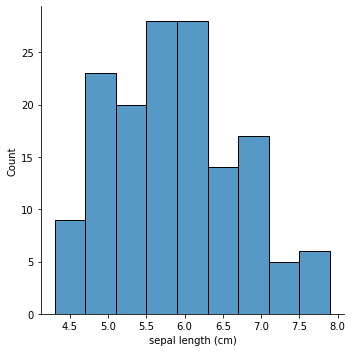

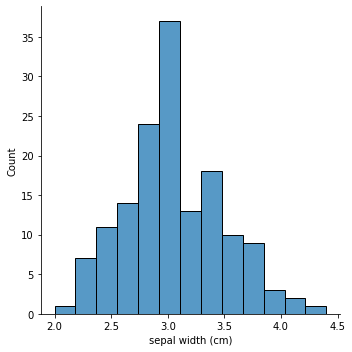

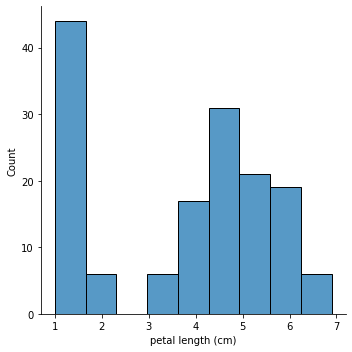

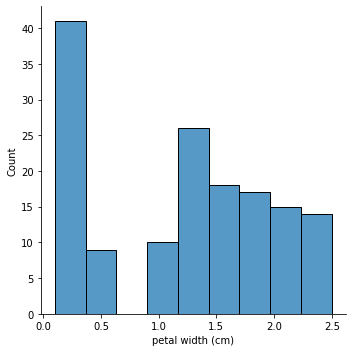

In [9]:
for col in feature_names:
    sns.displot(x=X[col])
#     plt.show()

##  Optimal Number of Cluters & Dimension Reduction

### Withouth Dimension Reduction

In [12]:
train_data = X 
cluster_nums = list(range(2, 10))

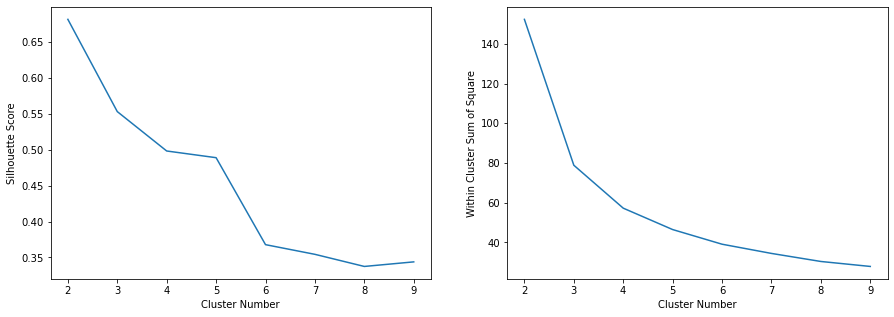

In [13]:
kmeans_optimal_cluster(X, cluster_nums)

### Dimension reduction with PCA

In [14]:
scaled_data = MinMaxScaler().fit_transform(X)

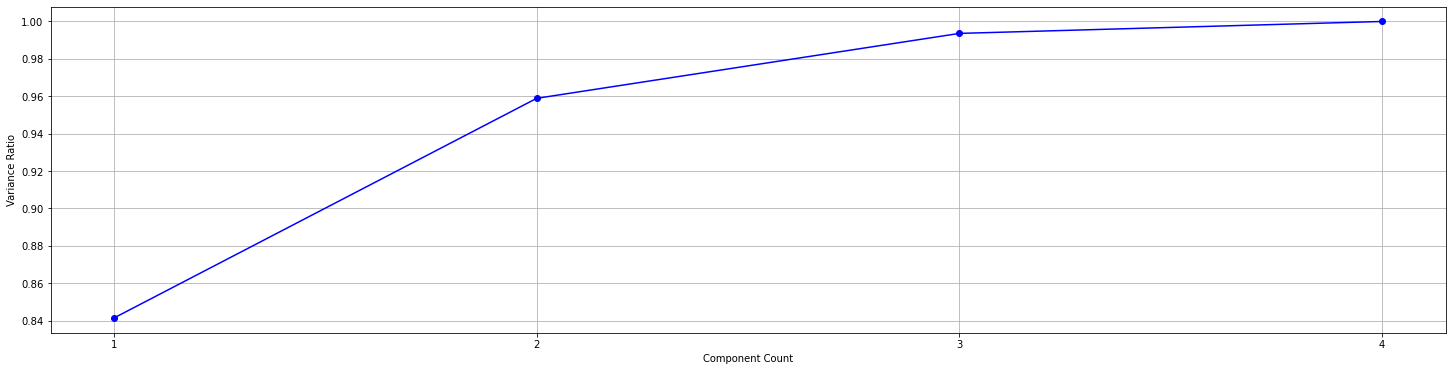

In [15]:
plot_pca_res(pd.DataFrame(scaled_data))

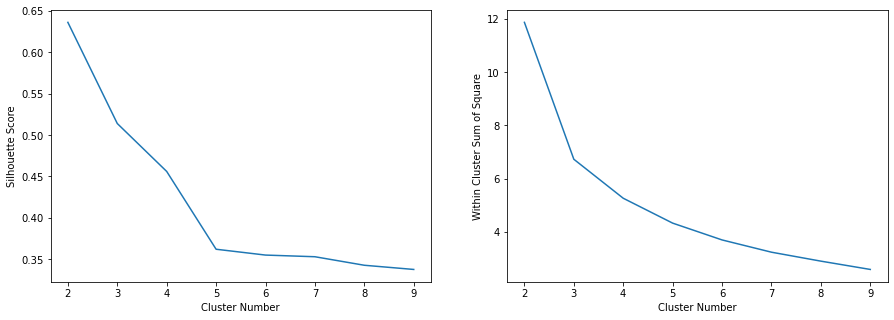

In [17]:
train_pca = PCA(n_components=3).fit_transform(scaled_data)
kmeans_optimal_cluster(train_pca, cluster_nums)

### t-sne dimension reduction

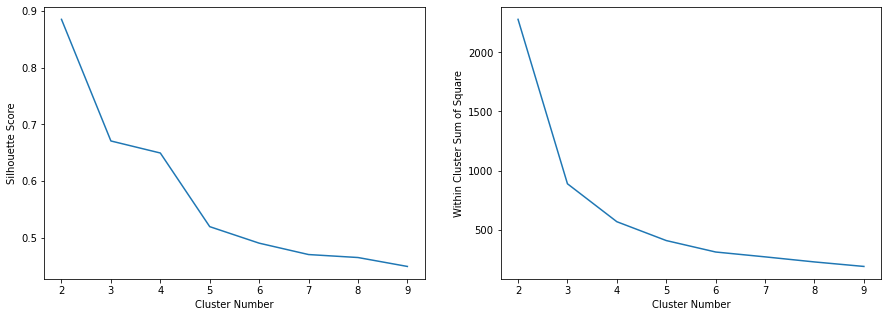

In [20]:
train_tsne = TSNE(n_components=2).fit_transform(scaled_data)
kmeans_optimal_cluster(train_tsne, cluster_nums)

## Model Training 

### Aglomerative Clustering (Hierarchical Clustering) 

<AxesSubplot:>

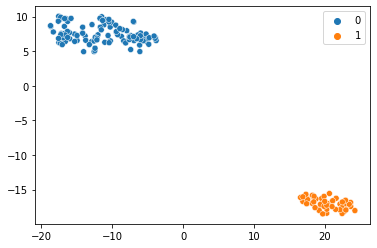

In [22]:
df = train_pca
tsne_df = train_tsne


res = AgglomerativeClustering().fit_predict(df)
sns.scatterplot(x=train_tsne[:, 0], y=train_tsne[:, 1], hue=res)

# TODO Text Clustering

In [4]:



# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

# parse commandline arguments
op = OptionParser()
op.add_option("--lsa",
              dest="n_components", type="int",
              help="Preprocess documents with latent semantic analysis.")
op.add_option("--no-minibatch",
              action="store_false", dest="minibatch", default=True,
              help="Use ordinary k-means algorithm (in batch mode).")
op.add_option("--no-idf",
              action="store_false", dest="use_idf", default=True,
              help="Disable Inverse Document Frequency feature weighting.")
op.add_option("--use-hashing",
              action="store_true", default=False,
              help="Use a hashing feature vectorizer")
op.add_option("--n-features", type=int, default=10000,
              help="Maximum number of features (dimensions)"
                   " to extract from text.")
op.add_option("--verbose",
              action="store_true", dest="verbose", default=False,
              help="Print progress reports inside k-means algorithm.")

print(__doc__)
op.print_help()


Automatically created module for IPython interactive environment
Usage: ipykernel_launcher.py [options]

Options:
  -h, --help            show this help message and exit
  --lsa=N_COMPONENTS    Preprocess documents with latent semantic analysis.
  --no-minibatch        Use ordinary k-means algorithm (in batch mode).
  --no-idf              Disable Inverse Document Frequency feature weighting.
  --use-hashing         Use a hashing feature vectorizer
  --n-features=N_FEATURES
                        Maximum number of features (dimensions) to extract
                        from text.
  --verbose             Print progress reports inside k-means algorithm.


In [5]:


def is_interactive():
    return not hasattr(sys.modules['__main__'], '__file__')


# work-around for Jupyter notebook and IPython console
argv = [] if is_interactive() else sys.argv[1:]
(opts, args) = op.parse_args(argv)
if len(args) > 0:
    op.error("this script takes no arguments.")
    sys.exit(1)


# #############################################################################
# Load some categories from the training set
categories = [
    'alt.atheism',
    'talk.religion.misc',
    'comp.graphics',
    'sci.space',
]
# Uncomment the following to do the analysis on all the categories
# categories = None

print("Loading 20 newsgroups dataset for categories:")
print(categories)

dataset = fetch_20newsgroups(subset='all', categories=categories,
                             shuffle=True, random_state=42)

print("%d documents" % len(dataset.data))
print("%d categories" % len(dataset.target_names))
print()

labels = dataset.target
true_k = np.unique(labels).shape[0]

print("Extracting features from the training dataset "
      "using a sparse vectorizer")
t0 = time()
if opts.use_hashing:
    if opts.use_idf:
        # Perform an IDF normalization on the output of HashingVectorizer
        hasher = HashingVectorizer(n_features=opts.n_features,
                                   stop_words='english', alternate_sign=False,
                                   norm=None)
        vectorizer = make_pipeline(hasher, TfidfTransformer())
    else:
        vectorizer = HashingVectorizer(n_features=opts.n_features,
                                       stop_words='english',
                                       alternate_sign=False, norm='l2')
else:
    vectorizer = TfidfVectorizer(max_df=0.5, max_features=opts.n_features,
                                 min_df=2, stop_words='english',
                                 use_idf=opts.use_idf)
X = vectorizer.fit_transform(dataset.data)

print("done in %fs" % (time() - t0))
print("n_samples: %d, n_features: %d" % X.shape)
print()

2021-10-17 13:33:41,681 INFO Downloading 20news dataset. This may take a few minutes.
2021-10-17 13:33:41,683 INFO Downloading dataset from https://ndownloader.figshare.com/files/5975967 (14 MB)


Loading 20 newsgroups dataset for categories:
['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
3387 documents
4 categories

Extracting features from the training dataset using a sparse vectorizer
done in 1.306286s
n_samples: 3387, n_features: 10000



In [6]:
X.shape

(3387, 10000)

In [7]:
X[0]

<1x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 89 stored elements in Compressed Sparse Row format>

In [8]:

if opts.n_components:
    print("Performing dimensionality reduction using LSA")
    t0 = time()
    # Vectorizer results are normalized, which makes KMeans behave as
    # spherical k-means for better results. Since LSA/SVD results are
    # not normalized, we have to redo the normalization.
    svd = TruncatedSVD(opts.n_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    X = lsa.fit_transform(X)

    print("done in %fs" % (time() - t0))

    explained_variance = svd.explained_variance_ratio_.sum()
    print("Explained variance of the SVD step: {}%".format(
        int(explained_variance * 100)))

    print()



In [9]:
opts.minibatch

True

In [10]:
X.shape

(3387, 10000)

In [11]:

# #############################################################################
# Do the actual clustering

if opts.minibatch:
    km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', n_init=1,
                         init_size=1000, batch_size=1000, verbose=opts.verbose)
else:
    km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1,
                verbose=opts.verbose)

print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X)
print("done in %0.3fs" % (time() - t0))
print()

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, km.labels_, sample_size=1000))

print()



Clustering sparse data with MiniBatchKMeans(batch_size=1000, init_size=1000, n_clusters=4, n_init=1,
                verbose=False)
done in 0.263s

Homogeneity: 0.460
Completeness: 0.508
V-measure: 0.483
Adjusted Rand-Index: 0.371
Silhouette Coefficient: 0.006



In [12]:

if not opts.use_hashing:
    print("Top terms per cluster:")

    if opts.n_components:
        original_space_centroids = svd.inverse_transform(km.cluster_centers_)
        order_centroids = original_space_centroids.argsort()[:, ::-1]
    else:
        order_centroids = km.cluster_centers_.argsort()[:, ::-1]

    terms = vectorizer.get_feature_names()
    for i in range(true_k):
        print("Cluster %d:" % i, end='')
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind], end='')
        print()

Top terms per cluster:
Cluster 0: space henry access nasa digex toronto pat alaska gov shuttle
Cluster 1: graphics image thanks files file university 3d gif program com
Cluster 2: god sandvik jesus kent apple com newton bible christian brian
Cluster 3: com article keith people don think sgi just posting like
